<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/main/High_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке развивается предсказатель высшей точки. Его цель - предсказывать, что мы находимя в локлаьном максимуме - цены выше на заданном горизонте в будущем не будет

In [3]:
#!pip install yfinance

In [1]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
%matplotlib inline

In [2]:
from methods import *

# Готовим данные

In [3]:
stocks = load_data("msft", period_start="2021-01-01")
print(stocks.shape[0])
stocks.head()

[*********************100%***********************]  1 of 1 completed
298


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,220.224811,220.689943,212.584781,215.434952,37130100
2021-01-05,215.009407,216.256364,213.465569,215.642776,23823000
2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700
2021-01-07,211.822773,217.067874,211.496205,216.028748,27694500
2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200


## Размечаем таргет

Размечаем таргет...


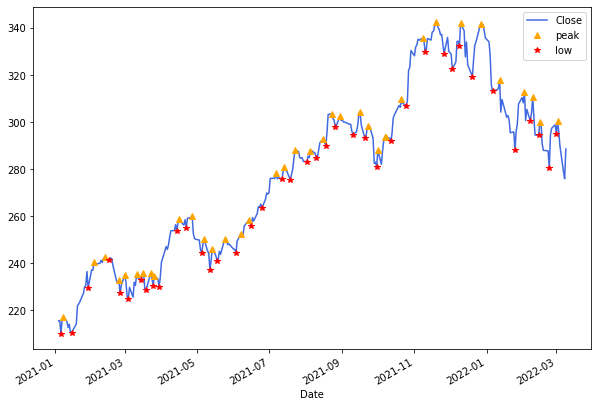

In [4]:
print("Размечаем таргет...")
mark_data_targets(stocks)

# отрисовываем график таргеты
stocks["Close"].plot(figsize=[10,7], color="royalblue")
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak", color="orange")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low", color="red")

_ = plt.legend()

## Расчитываем скользящие средние (СС)

Рассчитываем скользящие средние...


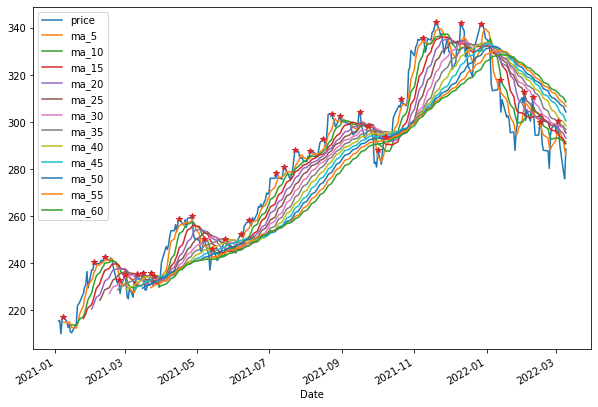

In [5]:
print("Рассчитываем скользящие средние...")
stocks_ma = create_ma(stocks["Close"], ma_steps=np.arange(5, 61, 5))

# Отрисовывем на обучении
_ = stocks_ma.plot(figsize=[10,7])
_ = stocks.loc[stocks["peaks"]==1, "Close"].plot(style="*")

## Отловим сигналы по СС

In [6]:
sell_signals, buy_signals = form_signals(stocks_ma)

## Разделение на обучение и тест

In [7]:
train_size = int(stocks_ma.shape[0]*2/3)
stocks_ma_train = stocks_ma[:train_size].copy(deep=True)
stocks_ma_test = stocks_ma[train_size:].copy(deep=True)

# Обучение

## Выбираем какая пара СС лучше предсказывает пик
пока лучшее, что было придумано - количество пропущенных пиков и рпсстояние до них
TODO: придумать адекватную метрики качества обнаружения пиков

In [8]:
#перебираем различные комбинации поиска сигналов на продажу и сигналов на покупку
ss_bs_chose_data = pd.DataFrame()
ss_bs_chose_data["price"] = stocks_ma_train["price"] 
ma_results = dict()

for ss_name in sell_signals.columns:
  ss_bs_chose_data["sell_signal"] = np.NaN
  ss_bs_chose_data.loc[sell_signals[ss_name]>0, "sell_signal"] = ss_bs_chose_data.loc[sell_signals[ss_name]>0, "price"]
  
  for bs_name in buy_signals.columns: 
    ss_bs_chose_data["buy_signal"] = np.NaN
    ss_bs_chose_data.loc[buy_signals[bs_name]>0, "buy_signal"] = ss_bs_chose_data.loc[buy_signals[bs_name]>0, "price"] 
    money_hist, money, eq = validate(ss_bs_chose_data, start_money = 10000, verbose=0)
    ma_results[ss_name+"+"+bs_name] = money

In [9]:
ma_results_pd = pd.DataFrame.from_dict(ma_results, orient="index", columns=["result"])
ma_results_pd.sort_values(by="result", ascending=False).head()

,result
ma_45_ma_55_sell_signal+ma_15_ma_35_buy_signal,14122.461578
ma_45_ma_55_sell_signal+ma_10_ma_40_buy_signal,14096.888565
ma_45_ma_50_sell_signal+ma_15_ma_35_buy_signal,14016.390289
ma_45_ma_50_sell_signal+ma_10_ma_40_buy_signal,13990.817276
ma_40_ma_55_sell_signal+ma_15_ma_35_buy_signal,13973.586395


In [10]:
chosen_sell_signals, chosen_buy_signals = ma_results_pd.sort_values(by="result", ascending=False).index.values[0].split("+")

In [11]:
print(chosen_sell_signals)
print(chosen_buy_signals)

ma_45_ma_55_sell_signal
ma_15_ma_35_buy_signal


# Применяем выбранные СС

In [12]:
train_data = apply_strategy(stocks_ma_train, 
               sell_signals=sell_signals, buy_signals = buy_signals,
               chosen_sell_signals = chosen_sell_signals, chosen_buy_signals=chosen_buy_signals)

test_data = apply_strategy(stocks_ma_test, 
               sell_signals=sell_signals, buy_signals = buy_signals,
               chosen_sell_signals = chosen_sell_signals, chosen_buy_signals=chosen_buy_signals)

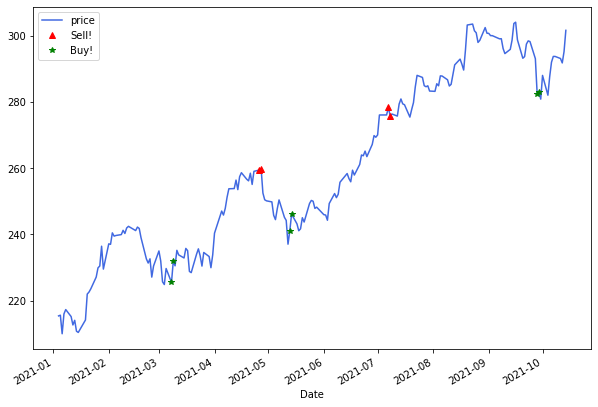

In [13]:
train_data["price"].plot(figsize=[10,7], color="royalblue")
train_data.loc[~np.isnan(train_data["sell_signal"]), "price"].plot(style="^", label="Sell!", color="red")
train_data.loc[~np.isnan(train_data["buy_signal"]), "price"].plot(style="*", label="Buy!", color="green")
plt.legend()

# Валидация стратегии

In [14]:
money_hist_train, money_train, eq_train = validate(train_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-03-08 00:00:00: Покупаем 44.0  по цене 225.55276489257812, остаток средств: 75.6783447265625
2021-03-09 00:00:00: Покупаем 0.0  по цене 231.89112854003906, остаток средств: 75.6783447265625
2021-04-26 00:00:00: Продаём 44.0  по цене 259.4367980957031, остаток средств: 11490.8974609375
2021-05-13 00:00:00: Покупаем 47.0  по цене 241.06640625, остаток средств: 160.7763671875
2021-05-14 00:00:00: Покупаем 0.0  по цене 246.14503479003906, остаток средств: 160.7763671875
2021-07-07 00:00:00: Продаём 47.0  по цене 278.3094177246094, остаток средств: 13241.31900024414
2021-09-28 00:00:00: Покупаем 46.0  по цене 282.41827392578125, остаток средств: 250.07839965820312
2021-09-29 00:00:00: Покупаем 0.0  по цене 282.8963928222656, остаток средств: 250.07839965820312
Денег в конце стратегии: 14122.46157836914


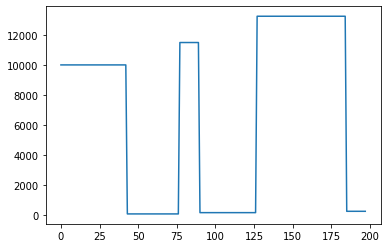

In [16]:
plt.plot(money_hist_train)

In [17]:
money_hist_test, money_test, eq_test = validate(test_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-12-13 00:00:00: Покупаем 29.0  по цене 338.69964599609375, остаток средств: 177.71026611328125
2021-12-14 00:00:00: Покупаем 0.0  по цене 327.6624755859375, остаток средств: 177.71026611328125
Денег в конце стратегии: 8544.210266113281


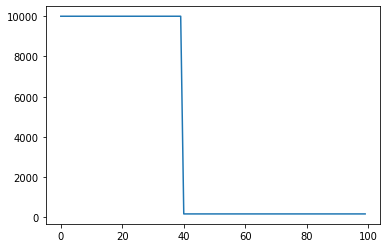

In [18]:
plt.plot(money_hist_test)